In [ ]:
%load_ext autoreload
%autoreload 2 

# On the previous episode...

On the previous lab we introduced neural network and implemented them using the `PyTorch` library. Our experiments showed that for image classification a CNN architecture yields good results on MNIST and, depending on the complexity of the network you created, "good" results on CIFAR10. However, dealing with MNIST someone might have gotten the wrong impression: "everythings work out-of-the-box or like magic in Deep Learning". Reality is not so rosy and we must go to great lengths do replicate our success on MNIST for other datasets.

In this lab, we will explore common pitfalls as well as common tips and tricks to resolve them. These simple methods will provide superior performance and are very easy to incorporate in our pipeline. 

Specifically, we will talk about:
* The importance of Learning Rate
* Batch Normalization
* Residual Connections

In the next lab, we will see more cool "tricks". 

So... let's get started!


For convenience, we copy-paste the necessary code from the previous lab. 

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Here we define the model modules
        

    def forward(self, x):
        # defines the forward function of the model. 
        raise NotImplementedError


    def fit(self, train_dataloader, optimizer, epochs, device, plot_loss=True):
        losses = []
        for epoch in range(epochs):
            running_loss = self.train_epoch(
                train_dataloader=train_dataloader, 
                optimizer=optimizer, 
                epoch_idx=epoch,
                device=device)
            
            losses.extend(running_loss)

        if plot_loss:
            self.plot_loss_progression(losses=losses)

    def plot_loss_progression(self, losses):
        plt.plot(losses)
        plt.xlabel('Steps')
        plt.ylabel("Loss")
        plt.title("Loss progression across steps")

    def train_epoch(self, train_dataloader, optimizer, epoch_idx, device):
        epoch_losses = []
        running_loss = 0.0

        self.train()
        tk0 = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch_idx}")
        for batch_idx, (data, target) in enumerate(tk0):
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = self(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            avg_loss = running_loss / (batch_idx + 1)
            tk0.set_postfix(loss=avg_loss, stage="train")
            epoch_losses.append(loss.item())

        
        return epoch_losses


    def predict(self, test_dataloader, device):
        self.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_dataloader:
                data, target = data.to(device), target.to(device)

                output = self(data)
                loss = F.cross_entropy(output, target)
                test_loss += loss.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /= len(test_dataloader.dataset)
        accuracy = 100. * correct / len(test_dataloader.dataset)

        print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')

For every model we want to create, we will create a new class that inherits `BasicModel` and implemements the `__init__` and `forward` functions. 

In [ ]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

In [ ]:
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)


In [ ]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda


In [ ]:
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


Now, let's visualize some samples.

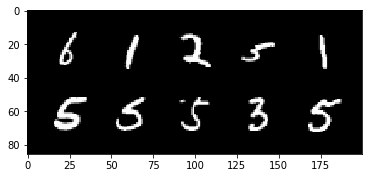

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

At first glance, we can see that this dataset is far more complex than MNIST.

## run simple model

In [ ]:
class CNN(BasicModel): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes   
        self.out = nn.Linear(1568, 10)    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   
        

Epoch 9: 100%|██████████| 59/59 [00:08<00:00,  6.84it/s, loss=2.24, stage=train]


Test set: Avg. loss: 0.0022, Accuracy: 3658/60000 (37%)


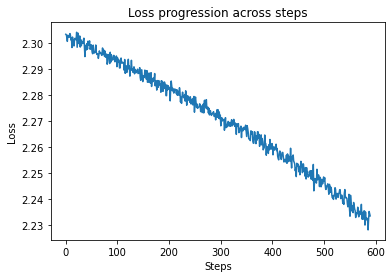

In [ ]:
cnn = CNN().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001)

cnn.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 10,
    device = DEVICE
)

cnn.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)

Epoch 4: 100%|██████████| 59/59 [00:08<00:00,  6.75it/s, loss=2.3, stage=train]


Test set: Avg. loss: 0.0023, Accuracy: 1135/60000 (11%)


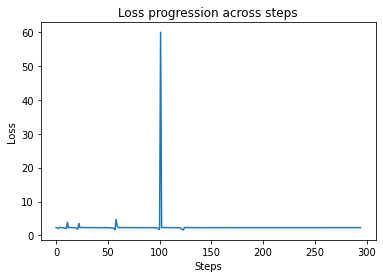

In [ ]:
cnn = CNN().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.9)

cnn.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 5,
    device = DEVICE
)

cnn.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)

# Momentum

In this lab we have used (mini-batch) Stochastic Gradient Descent or simply SGD. For simplicity we consider the case for only one sample. The update rule is the following:

$$
\mathbf{w}^{(\tau+1)} \gets \mathbf{w}^{(\tau)} - \eta\nabla \mathcal{L}\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
$$

How can we improve our algorithm and encourage faster convergence? Momentum can actually help. The idea is simple: we will use the update made on the previous step and incorporate it to our current update, giving momentum to our algorithm. The actual update rule is the following:

$$
\begin{align}
\mathbf{v}^{(\tau+1)} &\gets \gamma\mathbf{v}^{(\tau)} + \nabla \mathcal{L}\left(\mathbf{x}, y;\mathbf{w}^{(\tau)}\right)
\\
\mathbf{w}^{(\tau+1)} &\gets \mathbf{w}^{(\tau)} - \eta \mathbf{v}^{(\tau)}
\end{align}
$$

Apart from making convergence faster, momentum has other benefits:
* dampens oscillations 
* helps us navigate ravines around local optima [1]

If you are more interested in the various optimizers take a look at reference [1].

----
[1] Ruder, S., 2016. An overview of gradient descent optimization algorithms. arXiv preprint arXiv:1609.04747.



Epoch 9: 100%|██████████| 59/59 [00:08<00:00,  6.65it/s, loss=0.381, stage=train]


Test set: Avg. loss: 0.0004, Accuracy: 8966/60000 (90%)


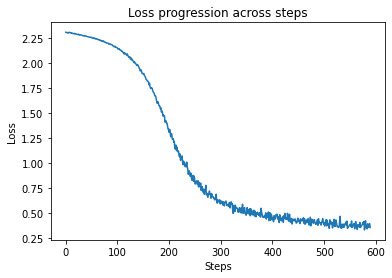

In [ ]:
# Let's change the "slow" version by simply adding momentum to the optimizer. 
# We will use the default value of \gamma=0.9
# What do you think will happen?

cnn = CNN().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

cnn.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 10,
    device = DEVICE
)

cnn.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)

# Batch normalization

We want to learn fast and converge at the same time. If we use a small learning rate, we will converge but it will be too slow. On the other hand, if we use large learning rate, our training will become inconsistent and we will bounce all over the place and never converge. Additionaly, higher learning rates  cause exploding or vanishing gradients i.e. the phenomenon where the multiplication of gradients via the chain rule induces a compound effect on the lower layers, preventing them from learning.

Can we have the best of both worlds? Enter **Batch Normalization**.

1. What does BatchNorm aims to solve? We want to
    * avoid unstable gradients,
    * allow faster learning rates leading to faster convergence,
    * reduce the effect of initialization.

2. Why does BatchNorm actually do?
    * Suppose we are given values of $x$ over a mini-batch $\mathcal{B}=\{x_i\}_{i=1}^m$. Our goal is to learn some parameters $\gamma$ and $\beta$ that perform the proper scaling.

    * First, we compute the mini-batch mean
    $$
    \mu_{\mathcal{B}}=\frac{1}{m}\sum_{i=1}^mx_i
    $$
    * and mini-batch variance
    $$
    \sigma^2_{\mathcal{B}}=\frac{1}{m}\sum_{i=1}^m (x_i-\mu_{\mathcal{B}})^2
    $$
    * we use these quantities to normalize our input
    $$
    \hat{x}_i=\frac{x_i-\mu_{\mathcal{B}}}{\sqrt{\sigma^2_{\mathcal{B}}+\epsilon}}
    $$
    * We scale, shift and return the output
    $$
    y_i=\gamma \hat{x}_i+\beta\equiv \text{BN}_{\gamma, \beta}(x_i)
    $$
    * Essentially, for each mini-batch we normalize the inputs by subtracting their mean and dividing by their standard deviation (estimated based on the statistics of the current mini-batch)  


3. Why does BatchNorm work?

    * BatchNorm is widely used (e.g. the original paper [1] has over 30000 citations). However, the reasons of its success are not perfectly clear.
    * The original authors claim that BatchNorm helps alleviate *Internal Covariate shift*, i.e. the phenomenon of shifting input distributions. Specifically, the input to each layer can be seen as a data distribution that the layer is trying to “learn”. The model, though, does not see the whole dataset but simply mini-batches. If this distribution stays consistent across batches, the layer can "learn effectively".  But, does this happen in practice?
    * the reality is that different mini-batches have different statistics, e.g. mean, variance etc, making the input distribution to the layers jump around. In other words, the input distribuion shifts for every mini-batch. We are trying to learn a "moving target". What if we stabilize it?
    * Batch normalization keeps the input normalized (duh!), preventing them from becoming too large or small and keeping the distribution consistent. 
    
    * It also directly placates the exploding/vanishing gradient problem and  allows higher learning rates.

    * However, other explanations have been proposed. [2] claims that BatchNorm "makes the optimization landscape significantly smoother. This smoothness induces a more predictive and stable behavior of the gradients, allowing for faster training".


---
[1] S. Ioffe and C. Szegedy, “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift,” in Proceedings of the 32nd International Conference on Machine Learning, Jun. 2015, pp. 448–456. Accessed: Oct. 25, 2021. [Online]. Available: https://proceedings.mlr.press/v37/ioffe15.html

[2] S. Santurkar, D. Tsipras, A. Ilyas, and A. Madry, “How Does Batch Normalization Help Optimization?,” in Advances in Neural Information Processing Systems, 2018, vol. 31. Accessed: Oct. 25, 2021. [Online]. Available: https://papers.nips.cc/paper/2018/hash/905056c1ac1dad141560467e0a99e1cf-Abstract.html



Files already downloaded and verified
Files already downloaded and verified


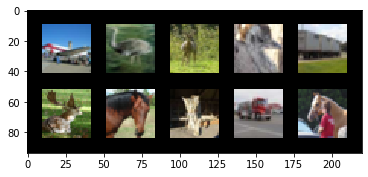

In [ ]:
# we make the Batch_sizes smaller for computational reasons
# we will later use larger models and memory might become an issue
BATCH_SIZE = 256
TEST_BATCH_SIZE = 256

transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
])

# load the train dataset
train_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.CIFAR10(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

show(grid)

In [ ]:
# redo the previous cnn architecture with batch normalization
# where does the batch normalization go?
class CNN_Cifar10(BasicModel): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)       
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   
        

Epoch 49: 100%|██████████| 196/196 [00:11<00:00, 17.81it/s, loss=0.655, stage=train]


Test set: Avg. loss: 0.0041, Accuracy: 6680/50000 (67%)


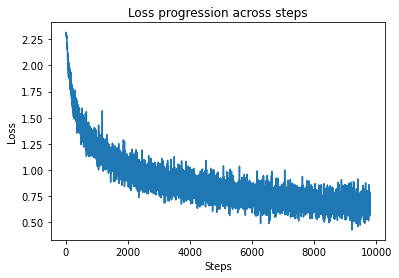

In [ ]:
cnn = CNN_Cifar10().to(DEVICE)
optimizer = torch.optim.SGD(cnn.parameters(), lr=0.01, momentum=0.9)

cnn.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 50,
    device = DEVICE
)

cnn.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)

In [ ]:
class CNNwithBN(BasicModel): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding=1,                  
            ),                              
            nn.ReLU(),   
            nn.BatchNorm2d(16),                   
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=3, 
                stride=1, 
                padding=1),     
            nn.ReLU(),        
            nn.BatchNorm2d(32),                   
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes
        self.out = nn.Linear(2048, 10)       
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1) 
        x = self.out(x)
        return x   

Epoch 49: 100%|██████████| 196/196 [00:11<00:00, 17.42it/s, loss=0.476, stage=train]


Test set: Avg. loss: 0.0048, Accuracy: 6710/50000 (67%)


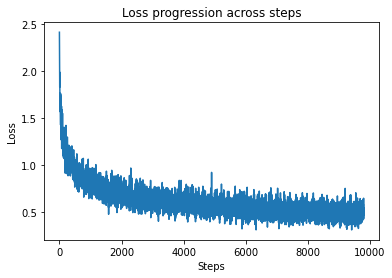

In [ ]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.01, momentum=0.9)

cnn2.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 50,
    device = DEVICE
)

cnn2.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)


One of the benefits of Batch Norm is that it allows us to use higher learning rates. Adapt the code above to do so. Does the model learn faster?


Epoch 49: 100%|██████████| 196/196 [00:11<00:00, 17.35it/s, loss=0.62, stage=train]


Test set: Avg. loss: 0.0046, Accuracy: 6557/50000 (66%)


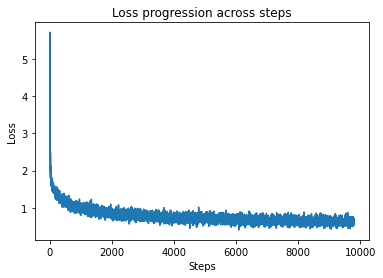

In [ ]:
cnn2 = CNNwithBN().to(DEVICE)
optimizer = torch.optim.SGD(cnn2.parameters(), lr=0.05, momentum=0.9)

cnn2.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 50,
    device = DEVICE
)

cnn2.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)


# Residual connections

As neural networks go deeper, they are able to construct complex representations and yield superior performance. However, we cannot simply stack as many layers as we want to increase the depth. 

![caption](media/resnet-no-skip-horizontal.png)

This is due to the **vanishing gradient** problem. Specifically, backpropagating the gradient to earlier layers involves repeated multiplication (with small values) rendering the gradient extremely small. This effectively means that as we go deeper, performance gets saturated. Instead of improved performance we even have degradation!

How can we reconcile this tradeoff? On the one hand, we want to increase depth but on the other hand this hurts convergence. 

Enter **skip connections** [3]! The network of the previous figure now becomes the following:

![caption](media/resnet-horizontal.png)

Now, let's think why these skip connections work. First, they allow the gradient to flow via this shortcut connection, which helps mitigate the problem of vanishing gradient. Second, they allow the model to learn the identity function. In other words, this ensures that the higher layer will perform at least as good as the lower layer.

---
[3] K. He, X. Zhang, S. Ren, and J. Sun, “Deep Residual Learning for Image Recognition,” in 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, Jun. 2016, pp. 770–778. doi: 10.1109/CVPR.2016.90.



First, we build the network of the first image, i.e. with no skip connections. The Resnet depicted above is characterized by an interesting pattern. It consists of "super-blocks" (see the different colors) and each one consists of two blocks that start after one residual connection and finish just before one. Notice that each color is associated with a different number, i.e. 64, 128, 256, 512. 

We will build a `nn.Module` for each block and repeat it to create the super-blocks and by extension the whole architecture.

The ResNet depicted above is meant to be used for `ImageNet`, a more complex dataset compared to `CIFAR10`. For computational considerations, we amend our implementation and make a simpler version.

In [ ]:
class WrongBlock(nn.Module):
    
    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels = in_planes,
            out_channels = planes, 
            kernel_size=3, 
            stride=stride, 
            padding=1, 
            bias=False)

        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(
            planes, 
            planes, 
            kernel_size=3,
            stride=1, 
            padding=1, 
            bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)

        return x


class ResNet(BasicModel):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes 
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



Epoch 49: 100%|██████████| 196/196 [02:19<00:00,  1.41it/s, loss=0.0252, stage=train]


Test set: Avg. loss: 0.0043, Accuracy: 8205/50000 (82%)


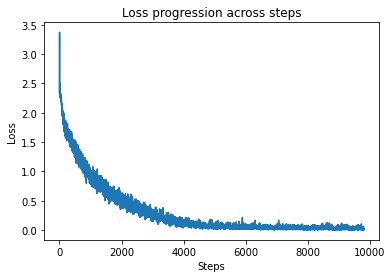

In [ ]:
# initialize the model 
model = ResNet(block=WrongBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
model.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 30,
    device = DEVICE
)

# predict with the trained model
model.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)


How many layers does the above model have?

Now, we add skip connections. Notice that sometimes the skip connection cannot be simply an identity function, since the dimensions will not match. Identify the condition when this is necessary. In that case, the shortcut function should be a convolution followed by BatchNorm. 

Fill the code below!

In [ ]:

class CorrectBlock(nn.Module):

    def __init__(self, in_planes, planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out += self.shortcut(x)
        out = F.relu(out)
        return out


In [ ]:
# initialize the model using the CorrectBlock module you created
model = ResNet(block=CorrectBlock, num_blocks=[2,2,2,2]).to(DEVICE)

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# train the ResNet
model.fit(
    train_dataloader = train_dataloader,
    optimizer = optimizer,
    epochs = 30,
    device = DEVICE
)

# predict with the trained model
model.predict(
    test_dataloader = test_dataloader,
    device = DEVICE
)


Epoch 24:  63%|██████▎   | 123/196 [01:31<00:54,  1.34it/s, loss=0.0307, stage=train]

In [ ]:
model